In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn

data retrival

In [2]:
# Prepare a dataFrame for results, used in the last part for a general comparison
compare = pd.DataFrame(columns=['model','Precision','Recall', 'F1 Score','M.A F1 Score'])

In [3]:

edges = pd.read_csv("elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_txs_features.csv",header=None)
classes = pd.read_csv("elliptic_txs_classes.csv")


In [4]:
print(edges.shape)
print(features.shape)
print(classes.shape)

(234355, 2)
(203769, 167)
(203769, 2)


In [5]:
#name all the features
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features

In [6]:
#merge features and classes
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: 0 if x == "unknown" else x)
features['class'] = features['class'].apply(lambda x: 1 if x == '1' else x)
features['class'] = features['class'].apply(lambda x: 2 if x == '2' else x)

<Axes: >

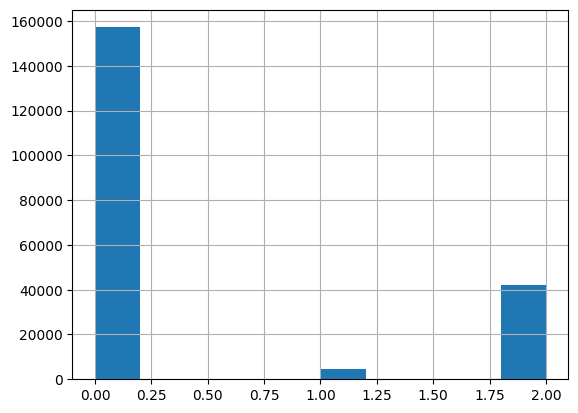

In [7]:
features['class'].hist()

# swap the index
For easier of use, we change the TxId identifier for the integer index. This simply many of the following considerations.

In [8]:
  class_values = sorted(features["class"].unique())
#we create a new index by sorting the tx_ids and assign to it a number
features_idx = {name: idx for idx, name in enumerate(sorted(features["txId"].unique()))}

# we then apply this new ids to all te data frames
# this helps a lot in computing the adjency matrix, having the ids as the index.
features["txId"] = features["txId"].apply(lambda name: features_idx[name])
edges["txId1"] = edges["txId1"].apply(lambda name: features_idx[name])
edges["txId2"] = edges["txId2"].apply(lambda name: features_idx[name])

# The tracker
The tracker is a function thats able to build the connected graph of a given transaction, displaying the graph, and compare it to the classified one. It can be used to look for particular clusters, for example the biggest connected graph, or it can be used to track a specific transaction.

**the tracking function**

In [11]:
# The tracker function recursively scans the network looking for the connected group to a given transaction.
# the deep levels represent the amount of recursive iterations it computes

def tracker(deep_levels, seed, edges):
  tmp = {seed}
  keep = set()
  counter = 0

  for i in range(deep_levels):
    for j in tmp:
      counter = counter + 1
      one = edges[edges['txId1'] == j]
      #add first
      tmp = set.union(tmp,set(one['txId2'].iloc[:]))

      two = edges[edges['txId2'] == j]
      #add second
      tmp = set.union(tmp,set(two['txId1'].iloc[:]))
      # check if connected group is empty
      if(len(one) == 0 & len(two) == 0):
          edgeList = edges[edges['txId1'].isin(keep)]
          return keep,edgeList,counter,True

      keep.add(j)
      tmp.remove(j)

  edgeList = edges[edges['txId1'].isin(keep)]
  return keep,edgeList,counter,False

In [12]:
def get_random_illicit(features):
  # get a random illicit transaction
  randomIllicit = features[features["class"] == 1].sample(1)["txId"]
  seed = randomIllicit.to_numpy()[0]
  # define the final DF containg the cluster
  return seed

In [13]:

def get_random_licit(features):
  # get a random illicit transaction
  randomLicit = features[features["class"] == 2].sample(1)["txId"]
  seed = randomLicit.to_numpy()[0]
  # define the final DF containg the cluster
  return seed

**Plot an example graph**

In [14]:
deep_levels = 20
keep = {}
tries = 0
minimum_nodes = 50

while(len(keep) < minimum_nodes):
  seed = get_random_illicit(features)
  keep,edgeList,counter,complete = tracker(deep_levels,seed,edges)
  tries = tries + 1

print("is the graph complete: ",complete)
print("iterations-> ",counter)
print("transactions found->",len(keep))
print("seed : ",seed)
print("seed tried:", tries)
print("transactions : \n")

print(edgeList)

is the graph complete:  True
iterations->  82
transactions found-> 76
seed :  137597
seed tried: 18
transactions : 

        txId1   txId2
57267  109354  110359
57364  109066  110314
57446  137653  110489
57447  107049  137593
57464  137597  110489
...       ...     ...
62702  110794  137652
62770  107820  108677
62799  137596  110489
62995  137621  110489
63018  108664  108665

[96 rows x 2 columns]


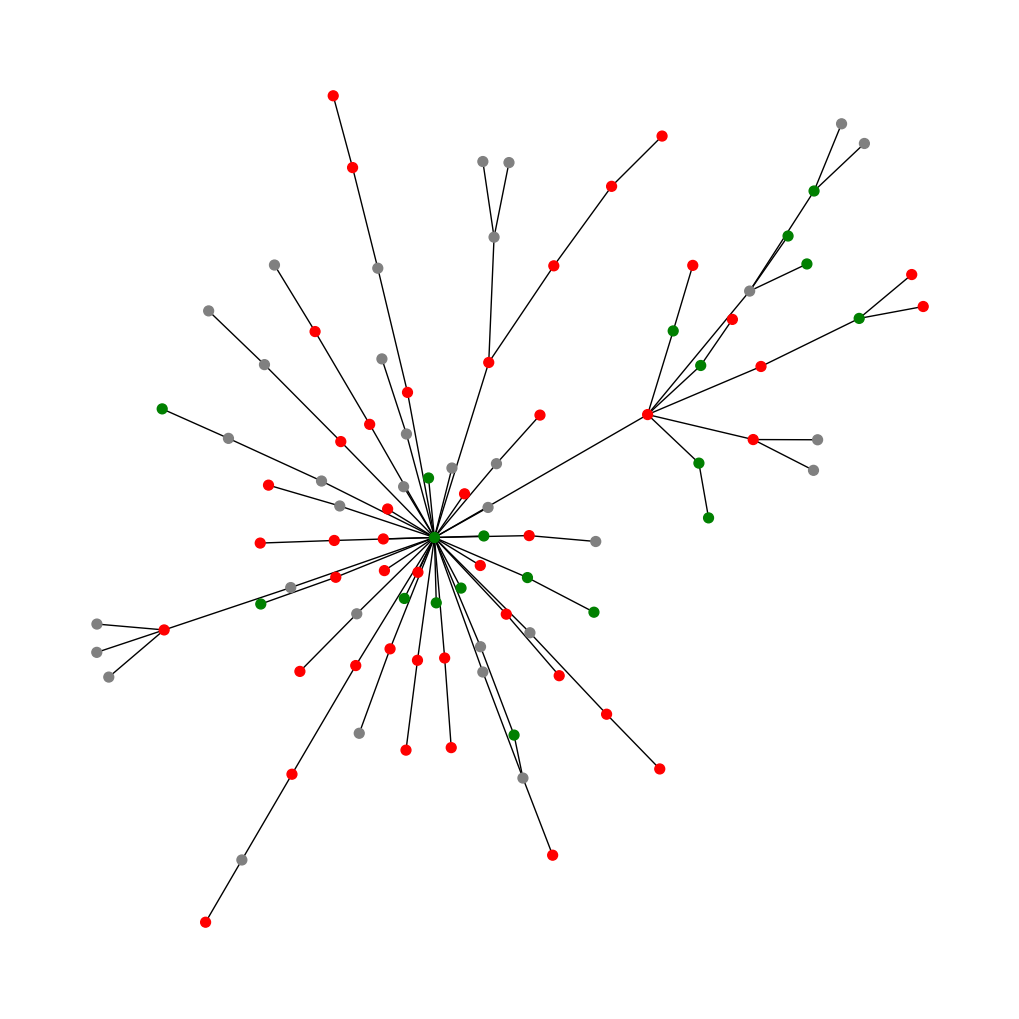

In [15]:

plt.figure(figsize=(10, 10))
import networkx as nx
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
#transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"]
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"]
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
nx.draw_spring(transaction_graph,node_size=50, node_color=list(transaction_type),width=1)

In [16]:
# helper function
def check(name):
  if(name in unique):
    return name
  else :
    return -1

In [17]:
# get the features of the known transactions
features_known = features[features['class'] != 0 ]
features_unknown = features[features['class'] == 0 ]
edges_known = edges.copy()

# remove from the edges DF all the entries that mentions the unknown transactions
unique = features_known['txId'].unique()
edges_known["txId1"] = edges["txId1"].apply(lambda name: check(name))
edges_known["txId2"] = edges["txId2"].apply(lambda name: check(name))

edges_known = edges_known[edges_known["txId1"] != -1 ]
edges_known = edges_known[edges_known["txId2"] != -1 ]

print(edges_known.shape)
print(features.shape)
print(features_known.shape)
print(features_unknown.shape)

(36624, 2)
(203769, 168)
(46564, 168)
(157205, 168)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [19]:
#Split the data, with the aggregated features

X = features_known[tx_features+agg_features]
y = features_known['class']
# this is important
y = y.apply(lambda x: 0 if x == 2 else 1 )
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=117,shuffle=False)
print("X_train shape",X_train.shape)
print("X_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

X_train shape (32594, 165)
X_test shape (13970, 165)
y_train shape (32594,)
y_test shape (13970,)


In [20]:
#Split the data, without the aggregated features

X_noAgg = features_known[tx_features]
y_noAgg = features_known['class']
# this is important
y_noAgg = y_noAgg.apply(lambda x: 0 if x == 2 else 1 )
X_train_noAgg, X_test_noAgg, y_train_noAgg, y_test_noAgg = train_test_split(X_noAgg,y_noAgg,test_size=0.3,random_state=117,shuffle=False)
print("X_train shape",X_train_noAgg.shape)
print("X_test shape",X_test_noAgg.shape)
print("y_train shape",y_train_noAgg.shape)
print("y_test shape",y_test_noAgg.shape)

X_train shape (32594, 93)
X_test shape (13970, 93)
y_train shape (32594,)
y_test shape (13970,)


In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [33]:
import torch
import torch.nn as nn

class EmbeddingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(EmbeddingMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        # Embedding layer: penultimate layer
        self.fc2 = nn.Linear(hidden_dim, embedding_dim)
        # Final classification layer (used during training)
        self.out = nn.Linear(embedding_dim, 2)  # Binary classification

    def forward(self, x, return_embedding=False):
        # Pass input through the network
        x = self.fc1(x)
        x = self.relu(x)
        embedding = self.fc2(x)

        # If return_embedding=True, return the embedding before classification
        if return_embedding:
            return embedding

        x = self.relu(embedding)
        x = self.out(x)
        return x


In [34]:

# Set hyperparameters for the MLP
input_dim = X_train.shape[1]
hidden_dim = 64
embedding_dim = 32

In [35]:
# Initialize the model
model = EmbeddingMLP(input_dim, hidden_dim, embedding_dim)


In [36]:
# ---------------------------
# Step 3: Train the MLP Model
# ---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

In [37]:

# Convert X_train to a NumPy array
X_train_array = X_train.to_numpy()

# Now convert to PyTorch tensor
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)

# Convert y_train to a PyTorch tensor
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)


In [38]:
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.7327
Epoch 10: Loss = 0.1902
Epoch 20: Loss = 0.1549
Epoch 30: Loss = 0.1337
Epoch 40: Loss = 0.1106


In [39]:
# ---------------------------
# Step 4: Extract Embeddings
# ---------------------------
model.eval()
with torch.no_grad():
    # Extract embeddings for both train and test sets
    # Convert X_train and X_test to NumPy arrays before creating tensors
    train_embeddings = model(torch.tensor(X_train.to_numpy(), dtype=torch.float32), return_embedding=True).numpy()
    test_embeddings = model(torch.tensor(X_test.to_numpy(), dtype=torch.float32), return_embedding=True).numpy()

In [40]:
# ---------------------------
# Step 5: Train a Traditional Classifier on the Embeddings (Hybrid Model)
# ---------------------------
# Here, we use RandomForestClassifier as an example
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_embeddings, y_train)
y_pred = rf.predict(test_embeddings)


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation results
print("Hybrid Model (MLP embeddings + RandomForest) Accuracy: {:.4f}".format(accuracy))
print("Hybrid Model (MLP embeddings + RandomForest) Precision: {:.4f}".format(precision))
print("Hybrid Model (MLP embeddings + RandomForest) Recall: {:.4f}".format(recall))
print("Hybrid Model (MLP embeddings + RandomForest) F1 Score: {:.4f}".format(f1))


Hybrid Model (MLP embeddings + RandomForest) Accuracy: 0.9763
Hybrid Model (MLP embeddings + RandomForest) Precision: 0.9388
Hybrid Model (MLP embeddings + RandomForest) Recall: 0.8097
Hybrid Model (MLP embeddings + RandomForest) F1 Score: 0.8695


In [46]:
# Assuming you have already loaded the data into `features` and merged with labels

# For data without aggregated features, select only the relevant columns (e.g., excluding aggregated features)
# Filter features to include only 'known' transactions to match y
features_known = features[features['class'] != 0]  # Filter out unknown transactions

X_no_aggregated = features_known.iloc[:, 2:95].values  # Assuming columns 2 to 94 are the raw features
y = features_known['class']
y = y.apply(lambda x: 0 if x == 2 else 1)  # Convert to binary classification


# Split the data into train and test sets
X_train_no_aggregated, X_test_no_aggregated, y_train_no_aggregated, y_test_no_aggregated = train_test_split(
    X_no_aggregated, y, test_size=0.2, stratify=y, random_state=42
)

In [47]:
# Convert to PyTorch tensors
X_train_tensor_no_aggregated = torch.tensor(X_train_no_aggregated, dtype=torch.float32)
y_train_tensor_no_aggregated = torch.tensor(y_train_no_aggregated.to_numpy(), dtype=torch.long)

# Initialize and train the model
model_no_aggregated = EmbeddingMLP(input_dim=X_train_no_aggregated.shape[1], hidden_dim=64, embedding_dim=32)

# Set up optimizer and loss function
optimizer = optim.Adam(model_no_aggregated.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model_no_aggregated.train()
    optimizer.zero_grad()
    outputs = model_no_aggregated(X_train_tensor_no_aggregated)
    loss = criterion(outputs, y_train_tensor_no_aggregated)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.5255
Epoch 10, Loss: 0.1956
Epoch 20, Loss: 0.1720
Epoch 30, Loss: 0.1572
Epoch 40, Loss: 0.1456


In [48]:
# Extract embeddings for the train and test data
model_no_aggregated.eval()
with torch.no_grad():
    train_embeddings_no_aggregated = model_no_aggregated(X_train_tensor_no_aggregated, return_embedding=True).numpy()
    test_embeddings_no_aggregated = model_no_aggregated(torch.tensor(X_test_no_aggregated, dtype=torch.float32), return_embedding=True).numpy()

# Train the RandomForest classifier on the embeddings
rf_no_aggregated = RandomForestClassifier(n_estimators=100, random_state=42)
rf_no_aggregated.fit(train_embeddings_no_aggregated, y_train_no_aggregated)

# Make predictions on the test set
y_pred_no_aggregated = rf_no_aggregated.predict(test_embeddings_no_aggregated)


In [49]:
# Evaluate the classifier
accuracy_no_aggregated = accuracy_score(y_test_no_aggregated, y_pred_no_aggregated)
precision_no_aggregated = precision_score(y_test_no_aggregated, y_pred_no_aggregated)
recall_no_aggregated = recall_score(y_test_no_aggregated, y_pred_no_aggregated)
f1_no_aggregated = f1_score(y_test_no_aggregated, y_pred_no_aggregated)

# Print the evaluation results
print("Hybrid Model (MLP embeddings + RandomForest) for Data without Aggregated Features")
print(f"Accuracy: {accuracy_no_aggregated:.4f}")
print(f"Precision: {precision_no_aggregated:.4f}")
print(f"Recall: {recall_no_aggregated:.4f}")
print(f"F1 Score: {f1_no_aggregated:.4f}")


Hybrid Model (MLP embeddings + RandomForest) for Data without Aggregated Features
Accuracy: 0.9786
Precision: 0.9598
Recall: 0.8152
F1 Score: 0.8816
